In [1]:
import pandas as pd
import gurobipy
import numpy as np

In [2]:
from utils import explain_one_to_one, explain_one_to_many, explain_many_to_one,explain_one_or_many, weighted_sum_ranking

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.transforms as transforms
from collections import defaultdict
import re

# RATP

Notre objectif est d’expliquer la sélection du meilleur projet, puis des 3 meilleurs, puis des 5 meilleurs. Nous souhaitons justifier ce choix à l’aide de comparaisons par paires. Il faut donc réfléchir à une manière intelligente de choisir les paires à comparer, puis exécuter successivement les algorithmes (1-1, 1-m, m-1, m-m).

### Charger le dataset


In [4]:
ratp_df = pd.read_excel('datasets/RATP.xlsx')
ratp_df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
2,NaN,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88
3,NaN,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95
4,NaN,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79
5,NaN,Nation (Ligne 9),74000,7100,42000,4550,77,15.2,73
6,NaN,La Motte Picquet-Grenelle (Ligne 10),72000,7500,33000,4250,88,13.2,93
7,NaN,Porte d'Orléans (Ligne 4),71000,7300,31500,4600,76,15.8,93
8,NaN,Daumenil (Ligne 6),79000,6900,39000,3800,67,16.8,79
9,NaN,Vaugirard (Ligne 12),57000,7600,40500,3800,82,17.2,77


In [5]:
#Supprimer la première colonne 
ratp_df = ratp_df.iloc[:, 1:]

# Mettre la ligne 1 comme header
ratp_df.columns = ratp_df.iloc[1]
ratp_df = ratp_df.drop(index=1)

# Extraire la ligne weights comme vecteur
weights_row = ratp_df.iloc[12, :]


# Vecteur numpy
weights = weights_row.iloc[1:].astype(float).to_numpy()

#  Série pandas avec labels
weights_series = weights_row.iloc[1:].astype(float)
weights_series.index = ratp_df.columns[1:]

# Supprimer les lignes vides (0, 12, la ligne weights)
ratp_df = ratp_df[~ratp_df.iloc[:, 0].isna()]
ratp_df = ratp_df[
    ratp_df.iloc[:, 0].astype(str).str.strip() != "weights"
]


In [6]:
ratp_df

1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
2,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88
3,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95
4,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79
5,Nation (Ligne 9),74000,7100,42000,4550,77,15.2,73
6,La Motte Picquet-Grenelle (Ligne 10),72000,7500,33000,4250,88,13.2,93
7,Porte d'Orléans (Ligne 4),71000,7300,31500,4600,76,15.8,93
8,Daumenil (Ligne 6),79000,6900,39000,3800,67,16.8,79
9,Vaugirard (Ligne 12),57000,7600,40500,3800,82,17.2,77
10,Oberkampf (Ligne 9),84000,7900,34000,3300,74,15.8,85
11,Reuilly-Diderot (Ligne 1),72000,8700,36000,4000,66,16.6,78


In [7]:
weights_series

1
peak-entering-passengers/h                    0.021498
peak-passing-passengers/h                     0.188111
off-peak-entering-passengers/h                0.037622
off-peak-passing-passengers/h                 0.322477
strategic priority [0,10]                    16.123831
Station degradation level ([0,20]  scale)    67.182629
connectivity index [0,100]                   16.123831
Name: 13, dtype: float64

In [8]:
cols = weights_series.index 
weighted_df = ratp_df.copy()
weighted_df[cols] = ratp_df[cols].mul(weights_series, axis=1)
weighted_df

1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
2,Odéon (Ligne 4),1827.367516,1523.702032,1335.59067,1112.544341,1209.287327,1088.358594,1418.89713
3,Place d'Italie (Lign 6),1741.37375,1523.702032,1410.835214,1015.801354,1080.296678,1182.414275,1531.763947
4,Jussieu (Ligne 7),1590.884661,1674.191121,1392.024078,1306.030313,1096.42051,1128.668172,1273.782651
5,Nation (Ligne 9),1590.884661,1335.59067,1580.13544,1467.268623,1241.534989,1021.175965,1177.039665
6,La Motte Picquet-Grenelle (Ligne 10),1547.887778,1410.835214,1241.534989,1370.525637,1418.89713,886.810706,1499.516285
7,Porte d'Orléans (Ligne 4),1526.389337,1373.212942,1185.10158,1483.392454,1225.411158,1061.485542,1499.516285
8,Daumenil (Ligne 6),1698.376868,1297.968397,1467.268623,1225.411158,1080.296678,1128.668172,1273.782651
9,Vaugirard (Ligne 12),1225.411158,1429.646351,1523.702032,1225.411158,1322.154144,1155.541223,1241.534989
10,Oberkampf (Ligne 9),1805.869074,1486.079759,1279.157261,1064.172847,1193.163496,1061.485542,1370.525637
11,Reuilly-Diderot (Ligne 1),1547.887778,1636.568849,1354.401806,1289.906482,1064.172847,1115.231646,1257.65882


In [9]:
print("ratp_df columns:", list(ratp_df.columns))
print("weights index:", list(weights_series.index))

ratp_df columns: ['Metro station', 'peak-entering-passengers/h', 'peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
weights index: ['peak-entering-passengers/h', 'peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']


### Calcul du vrai classement

Pour établir le classement de référence, on calcule un score pour chaque station à l’aide d’une somme pondérée des critères, puis on ordonne les stations par score décroissant.


In [10]:
ranked_df, weights_aligned = weighted_sum_ranking(ratp_df, weights_series, normalize_weights=False)


In [11]:
top3 = ranked_df.head(3)
top3

1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]",score
2,Odéon (Ligne 4),85000,8100,35500,3450,75,16.2,88,9515.747608
3,Place d'Italie (Lign 6),81000,8100,37500,3150,67,17.6,95,9486.187251
4,Jussieu (Ligne 7),74000,8900,37000,4050,68,16.8,79,9462.001505


In [12]:
station_col = "Metro station"

stations_ranked = ranked_df.index.tolist()


order = ranked_df[station_col].tolist()
for i, s in zip(order,stations_ranked):
    print(i, s)


weighted_df_ordered = (
    weighted_df
    .set_index(station_col)
    .loc[order]
    .reset_index()
)

weighted_df_ordered


Odéon (Ligne 4) 2
Place d'Italie (Lign 6) 3
Jussieu (Ligne 7) 4
Nation (Ligne 9) 5
La Motte Picquet-Grenelle (Ligne 10) 6
Porte d'Orléans (Ligne 4) 7
Reuilly-Diderot (Ligne 1) 11
Oberkampf (Ligne 9) 10
Daumenil (Ligne 6) 8
Vaugirard (Ligne 12) 9


1,Metro station,peak-entering-passengers/h,peak-passing-passengers/h,off-peak-entering-passengers/h,off-peak-passing-passengers/h,"strategic priority [0,10]","Station degradation level ([0,20] scale)","connectivity index [0,100]"
0,Odéon (Ligne 4),1827.367516,1523.702032,1335.59067,1112.544341,1209.287327,1088.358594,1418.89713
1,Place d'Italie (Lign 6),1741.37375,1523.702032,1410.835214,1015.801354,1080.296678,1182.414275,1531.763947
2,Jussieu (Ligne 7),1590.884661,1674.191121,1392.024078,1306.030313,1096.42051,1128.668172,1273.782651
3,Nation (Ligne 9),1590.884661,1335.59067,1580.13544,1467.268623,1241.534989,1021.175965,1177.039665
4,La Motte Picquet-Grenelle (Ligne 10),1547.887778,1410.835214,1241.534989,1370.525637,1418.89713,886.810706,1499.516285
5,Porte d'Orléans (Ligne 4),1526.389337,1373.212942,1185.10158,1483.392454,1225.411158,1061.485542,1499.516285
6,Reuilly-Diderot (Ligne 1),1547.887778,1636.568849,1354.401806,1289.906482,1064.172847,1115.231646,1257.65882
7,Oberkampf (Ligne 9),1805.869074,1486.079759,1279.157261,1064.172847,1193.163496,1061.485542,1370.525637
8,Daumenil (Ligne 6),1698.376868,1297.968397,1467.268623,1225.411158,1080.296678,1128.668172,1273.782651
9,Vaugirard (Ligne 12),1225.411158,1429.646351,1523.702032,1225.411158,1322.154144,1155.541223,1241.534989


### Explication du classement

On va maintenant appliquer notre méthode 1–1 pour essayer d’expliquer le choix des trois meilleures stations.


**Stratégie 1**
1. On compare les trois premières stations entre elles, dans l’ordre, pour justifier le classement ($1$ vs $2$, puis $2$ vs $3$).
2. On compare ensuite toutes les autres stations (rang >= $4$) à la 3ème station (qui sert de “seuil” du top-$3$).


**Stratégie 2**

On compare les stations voisines dans l’ordre du classement pour établir/justifier le ranking ($1$ vs $2$, $2$ vs $3$, …, $n−1$ vs $n$).

In [13]:
score_col = "score"

# Colonnes de critères = celles des poids 
criteria = list(weights_series.index)

# On s'assure que ranked_df est trié
ranked_df = ranked_df.sort_values(score_col, ascending=False)

# Liste ordonnée des stations
stations_ranked = ranked_df.index.tolist()
print("Ordre stations:", stations_ranked)

top3 = stations_ranked[:3]
rest = stations_ranked[3:]

print("Top 3:", top3)
print("Nb autres:", len(rest))


Ordre stations: [2, 3, 4, 5, 6, 7, 11, 10, 8, 9]
Top 3: [2, 3, 4]
Nb autres: 7


In [14]:
def explain_pair(
    station_x,
    station_y,
    *,
    explain_fn=explain_one_to_one,
    explain_kwargs=None,
    eps_zero=0.0,
    gurobi_output=False,
):
    """
    Explique la comparaison station_x ≻ station_y en appelant une fonction d'explication configurable.

    Paramètres
    ----------
    station_x, station_y : str
        Noms (index) des stations dans ratp_df.
    explain_fn : callable
        Fonction d'explication à appeler. Signature attendue (au minimum) :
            explain_fn(x_vec, y_vec, weights, criteria, **kwargs) -> dict
        Par défaut : explain_one_to_one
    explain_kwargs : dict ou None
        Dictionnaire d'arguments supplémentaires passés à explain_fn.
        (Utile si tu changes de méthode d'explication.)
    eps_zero, gurobi_output :
        Passés à explain_fn si elle les accepte (cas explain_one_to_one).

    Retour
    ------
    dict : résultat + champs "x" et "y" (noms des stations)
    """
    if explain_kwargs is None:
        explain_kwargs = {}

    x_vec = ratp_df.loc[station_x, criteria].to_numpy(dtype=float)
    y_vec = ratp_df.loc[station_y, criteria].to_numpy(dtype=float)

    # kwargs par défaut 
    base_kwargs = dict(eps_zero=eps_zero, gurobi_output=gurobi_output)
    base_kwargs.update(explain_kwargs)

    res = explain_fn(
        x_vec=x_vec,
        y_vec=y_vec,
        weights=weights_series.to_numpy(dtype=float),
        criteria=criteria,
        **base_kwargs,
    )

    res["x"] = station_x
    res["y"] = station_y
    return res



In [15]:
def pretty_print_explanation(res, max_pairs=None):
    x, y = res["x"], res["y"]
    print(f"\n=== Explication 1-1 pour: {x} ≻ {y} ===")
    print("feasible:", res["feasible"])
    print("pros:", res["pros"])
    print("cons:", res["cons"])
    print("neutral:", res["neutral"])

    if res["feasible"]:
        pairs = res["selected_pairs"]
        if max_pairs is not None:
            pairs = pairs[:max_pairs]
        print("\nPaires (p,c) retenues :")
        for (p, c) in pairs:
            dp, dc = res["d"][p], res["d"][c]
            print(f" - ({p},{c}) : {p}({dp:+.3f}) compense {c}({dc:+.3f})  => somme={dp+dc:+.3f}")
        print("Longueur l =", len(res["selected_pairs"]))
    else:
        print("\nInfaisable.")
        print("IIS / diagnostic:", res.get("iis_constraints"))


### Stratégie 1

In [16]:
def run_strategy_1(sorted_dataset, top_k=3, eps_zero=0.0, gurobi_output=False):
    """
    Explication 1–1 généralisée pour justifier le top-k à partir d'un dataset déjà trié
    (du meilleur au pire).

    1) Ordre interne du top-k via comparaisons adjacentes : 1 ≻ 2 ≻ ... ≻ k
    2) Seuil : (kᵉ) ≻ i pour tout i > k
    """
    results = []

    # Sécurité : si top_k dépasse la taille
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = sorted_dataset[:top_k]
    rest = sorted_dataset[top_k:]

    # ordre interne du top-k (rien à faire si top_k == 1)
    #for a, b in zip(topk[:-1], topk[1:]):
    #    results.append(explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output))

    threshold = topk[-1]
    for si in topk[:-1]:
        results.append(explain_pair(si,threshold, eps_zero=eps_zero, gurobi_output=gurobi_output))
    
    # seuil : le dernier du top-k domine tous les suivants
    if top_k >= 1:
        threshold = topk[-1]
        for si in rest:
            results.append(explain_pair(threshold, si, eps_zero=eps_zero, gurobi_output=gurobi_output))

    return results



strategy1_results = run_strategy_1(sorted_dataset=stations_ranked, top_k=3, eps_zero=0.0, gurobi_output=False)

print("Nb comparaisons (stratégie 1):", len(strategy1_results))
print("Nb infaisables:", sum(1 for r in strategy1_results if not r["feasible"]))


Set parameter Username
Set parameter LicenseID to value 2755074
Academic license - for non-commercial use only - expires 2026-12-15
Nb comparaisons (stratégie 1): 9
Nb infaisables: 5


In [17]:
pretty_print_explanation(strategy1_results[4])



=== Explication 1-1 pour: 4 ≻ 7 ===
feasible: False
pros: ['peak-entering-passengers/h', 'peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)']
cons: ['off-peak-passing-passengers/h', 'strategic priority [0,10]', 'connectivity index [0,100]']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]', 'cover_cons[strategic priority [0,10]]', 'cover_cons[connectivity index [0,100]]', 'use_pro_at_most_once[peak-passing-passengers/h]', 'use_pro_at_most_once[off-peak-entering-passengers/h]']


### Stratégie 2

In [18]:
def run_strategy_2(eps_zero=0.0, gurobi_output=False):
    
    """
    Applique la méthode d'explication 1–1 en comparant les voisins du classement.

    Stratégie 2
    -----------
    Comparer les stations voisines dans l'ordre du classement pour établir/justifier
    le ranking (1 ≻ 2, 2 ≻ 3, ..., n−1 ≻ n).

    Par transitivité, ces comparaisons locales peuvent servir à justifier des relations
    plus globales dans le classement.
    """
    
    results = []
    for i in range(len(stations_ranked) - 1):
        a = stations_ranked[i]
        b = stations_ranked[i + 1]
        results.append(explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output))
    return results

strategy2_results = run_strategy_2(eps_zero=0.0, gurobi_output=False)

print("Nb comparaisons (stratégie 2):", len(strategy2_results))
print("Nb infaisables:", sum(1 for r in strategy2_results if not r["feasible"]))


Nb comparaisons (stratégie 2): 9
Nb infaisables: 8


In [19]:
pretty_print_explanation(strategy2_results[0])


=== Explication 1-1 pour: 2 ≻ 3 ===
feasible: True
pros: ['peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
cons: ['off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
neutral: ['peak-passing-passengers/h']

Paires (p,c) retenues :
 - (peak-entering-passengers/h,off-peak-entering-passengers/h) : peak-entering-passengers/h(+85.994) compense off-peak-entering-passengers/h(-75.245)  => somme=+10.749
 - (off-peak-passing-passengers/h,Station degradation level ([0,20]  scale)) : off-peak-passing-passengers/h(+96.743) compense Station degradation level ([0,20]  scale)(-94.056)  => somme=+2.687
 - (strategic priority [0,10],connectivity index [0,100]) : strategic priority [0,10](+128.991) compense connectivity index [0,100](-112.867)  => somme=+16.124
Longueur l = 3


### Commentaires

On remarque qu'en pratique il est plus intéressant d'utiliser la stratégie 1 car le seuil est plus grand que les suivants donc il est plus probable qu'on trouve une explication plus simple: ie 1-1

In [20]:
for i, res in enumerate(strategy1_results, start=1):
    print(f"\n### Stratégie 1 — explication {i}/{len(strategy1_results)}")
    pretty_print_explanation(res)



### Stratégie 1 — explication 1/9

=== Explication 1-1 pour: 2 ≻ 4 ===
feasible: False
pros: ['peak-entering-passengers/h', 'strategic priority [0,10]', 'connectivity index [0,100]']
cons: ['peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'Station degradation level ([0,20]  scale)']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[peak-passing-passengers/h]', 'cover_cons[off-peak-passing-passengers/h]', 'use_pro_at_most_once[peak-entering-passengers/h]']

### Stratégie 1 — explication 2/9

=== Explication 1-1 pour: 3 ≻ 4 ===
feasible: False
pros: ['peak-entering-passengers/h', 'off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
cons: ['peak-passing-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]']

### Stratégie 1 — explication 3/9

=== Explication 1-1 pour: 4 ≻

In [21]:
for i, res in enumerate(strategy1_results, start=1):
    if not res["feasible"]:
        print(f"\n### Stratégie 1 — INFEASIBLE {i}/{len(strategy1_results)}")
        pretty_print_explanation(res)



### Stratégie 1 — INFEASIBLE 1/9

=== Explication 1-1 pour: 2 ≻ 4 ===
feasible: False
pros: ['peak-entering-passengers/h', 'strategic priority [0,10]', 'connectivity index [0,100]']
cons: ['peak-passing-passengers/h', 'off-peak-entering-passengers/h', 'off-peak-passing-passengers/h', 'Station degradation level ([0,20]  scale)']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[peak-passing-passengers/h]', 'cover_cons[off-peak-passing-passengers/h]', 'use_pro_at_most_once[peak-entering-passengers/h]']

### Stratégie 1 — INFEASIBLE 2/9

=== Explication 1-1 pour: 3 ≻ 4 ===
feasible: False
pros: ['peak-entering-passengers/h', 'off-peak-entering-passengers/h', 'Station degradation level ([0,20]  scale)', 'connectivity index [0,100]']
cons: ['peak-passing-passengers/h', 'off-peak-passing-passengers/h', 'strategic priority [0,10]']
neutral: []

Infaisable.
IIS / diagnostic: ['cover_cons[off-peak-passing-passengers/h]']

### Stratégie 1 — INFEASIBLE 3/9

=== Explication 1-1 pour: 4 ≻ 5 

### Stratégie 3

Cependant, on constate qu’avec la stratégie 1–1, on ne parvient pas à expliquer toutes les paires sélectionnées. On peut donc chercher une couverture différente des comparaisons.

Par exemple, pour le top-3 : les comparaisons (3,4) et (3,5) fonctionnent, mais (3,6) échoue. On essaie alors de passer par une autre chaîne de comparaisons, par exemple en comparant d’abord 6 à 4, puis 6 à 3.


In [22]:
def run_strategy_3_descend_from_threshold(
    sorted_dataset,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True,
):
    """
    Stratégie 3 "descente":
      - HAUT: on force/cherche des liens vers le seuil par descente (transitivité correcte)
      - BAS: inchangé (exactement ton algo 1)
    """
    results = []
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = list(sorted_dataset[:top_k])      # rangs 1..k
    rest = list(sorted_dataset[top_k:])      # rangs k+1..n

    def compare_and_log(a, b, note=""):
        if verbose:
            prefix = f"[{note}] " if note else ""
            print(f"{prefix}Comparaison: {a} ≻ {b}")
        return explain_pair(a, b, eps_zero=eps_zero, gurobi_output=gurobi_output)

    # -------------------------
    # 0) ordre interne top-k (base)
    # -------------------------
    # (on le garde: utile pour le plot + base de chaîne)
    for a, b in zip(topk[:-1], topk[1:]):
        results.append(compare_and_log(a, b, note="ordre top-k"))

    if top_k == 0:
        return results, set(), set()

    threshold = topk[-1]  # rang k

    # -------------------------
    # 1) HAUT: descente vers le seuil (comme ton bas, mais en "inverse")
    # -------------------------
    # Pour chaque station au-dessus du seuil (rang 1..k-1),
    # on veut trouver une preuve (directe ou via un intermédiaire) que station ≻ seuil.
    # Logique: essayer directement i ≻ seuil, sinon essayer i ≻ cand pour cand dans (i+1..k-1),
    # du plus proche au plus bas (descente).
    connected_top = set()
    not_connected_top = set()

    for i in range(0, top_k - 1):  # indices 0..k-2
        si = topk[i]
        found = False

        # candidats: seuil (k-1) puis i+1 ... jusqu'à k-2
        # (on "descend" depuis le bas de la zone top vers le seuil)
        cand_indices = [top_k - 1] + list(range(i + 1, top_k - 1))
        for cand_idx in cand_indices:
            cand = topk[cand_idx]
            note = "seuil" if cand_idx == top_k - 1 else f"descend via rang {cand_idx+1}"
            res = compare_and_log(si, cand, note=f"haut {note}")
            results.append(res)

            if res.get("feasible", False):
                connected_top.add(si)
                found = True
                break

        if not found:
            not_connected_top.add(si)
            if verbose:
                print(f"[echec haut] Aucun candidat entre {si} et le seuil (rang {top_k}) ne marche.")

    # -------------------------
    # 2) BAS: INCHANGÉ = ton algo 1
    # -------------------------
    connected_rest = set()
    not_connected_rest = set()

    pos = {node: i for i, node in enumerate(sorted_dataset)}  # 0-based
    k_idx = top_k - 1  # index du seuil dans sorted_dataset

    for si in rest:
        r_idx = pos[si]
        found = False

        # candidats: seuil (k_idx) puis k_idx+1 ... jusqu'à juste avant si (r_idx-1)
        for cand_idx in range(k_idx, r_idx):
            cand = sorted_dataset[cand_idx]
            note = "seuil" if cand_idx == k_idx else f"descend via rang {cand_idx+1}"
            res = compare_and_log(cand, si, note=note)
            results.append(res)

            if res.get("feasible", False):
                connected_rest.add(si)
                found = True
                break

        if not found:
            not_connected_rest.add(si)
            if verbose:
                print(f"[echec] Aucun candidat entre le seuil (rang {top_k}) et {si} ne marche.")

    # si tu veux retourner aussi l'état du haut:
    # return results, connected_rest, not_connected_rest, connected_top, not_connected_top
    return results, connected_rest, not_connected_rest


In [23]:
strategy3d_results, connected_rest, not_connected_rest = run_strategy_3_descend_from_threshold(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)


print("Connectés:", connected_rest)
print("Non connectés:", not_connected_rest)


[ordre top-k] Comparaison: 2 ≻ 3
[ordre top-k] Comparaison: 3 ≻ 4
[haut seuil] Comparaison: 2 ≻ 4
[haut descend via rang 2] Comparaison: 2 ≻ 3
[haut seuil] Comparaison: 3 ≻ 4
[echec haut] Aucun candidat entre 3 et le seuil (rang 3) ne marche.
[seuil] Comparaison: 4 ≻ 5
[echec] Aucun candidat entre le seuil (rang 3) et 5 ne marche.
[seuil] Comparaison: 4 ≻ 6
[descend via rang 4] Comparaison: 5 ≻ 6
[echec] Aucun candidat entre le seuil (rang 3) et 6 ne marche.
[seuil] Comparaison: 4 ≻ 7
[descend via rang 4] Comparaison: 5 ≻ 7
[descend via rang 5] Comparaison: 6 ≻ 7
[echec] Aucun candidat entre le seuil (rang 3) et 7 ne marche.
[seuil] Comparaison: 4 ≻ 11
[seuil] Comparaison: 4 ≻ 10
[seuil] Comparaison: 4 ≻ 8
[seuil] Comparaison: 4 ≻ 9
Connectés: {8, 9, 10, 11}
Non connectés: {5, 6, 7}


## Plots 

In [24]:
from utils_plots import plot_strategy_graph

In [25]:
station_name_map = ratp_df["Metro station"].to_dict()

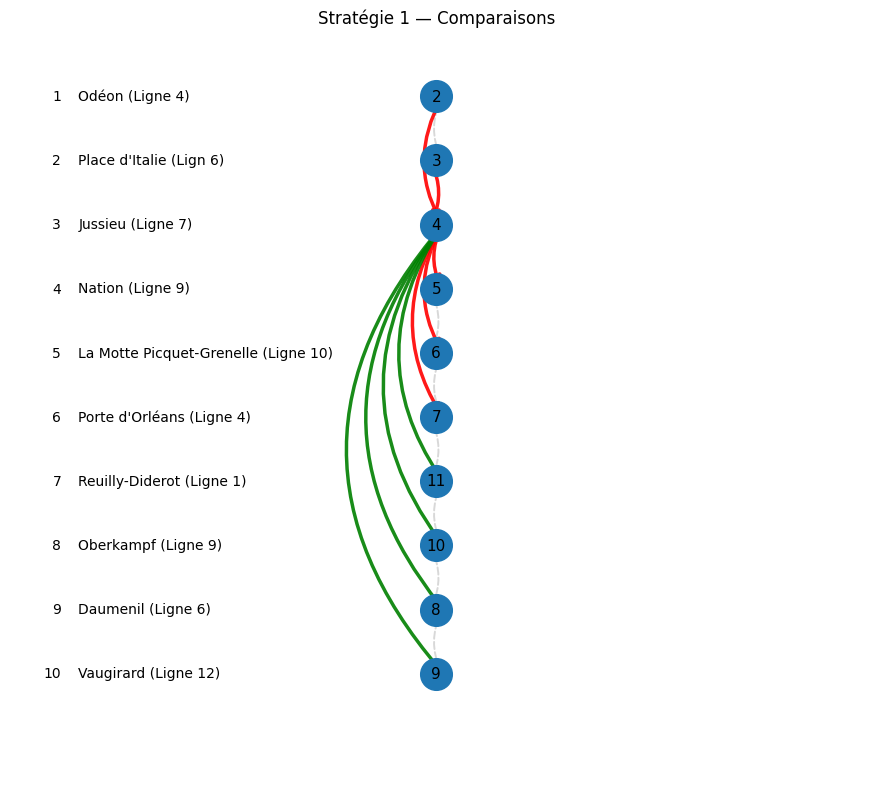

In [26]:
strategy1_results = run_strategy_1(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False
)

plot_strategy_graph(station_name_map=station_name_map,
    stations_ranked=stations_ranked,
    results=strategy1_results,
    title="Stratégie 1 — Comparaisons",
    show_gray_neighbors=True,
    alternate_sides=True
)


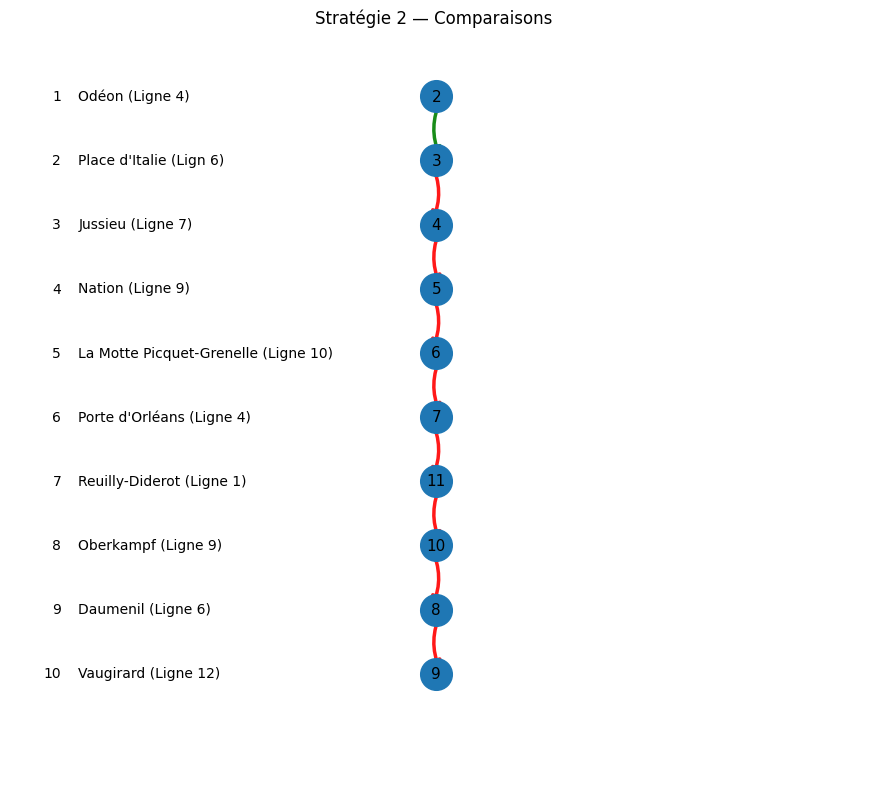

In [27]:
strategy2_results = run_strategy_2(eps_zero=0.0, gurobi_output=False)

plot_strategy_graph(station_name_map=station_name_map,
    stations_ranked=stations_ranked,
    results=strategy2_results,
    title="Stratégie 2 — Comparaisons ",
    show_gray_neighbors=True,
    alternate_sides=True
)


[ordre top-k] Comparaison: 2 ≻ 3
[ordre top-k] Comparaison: 3 ≻ 4
[haut seuil] Comparaison: 2 ≻ 4
[haut descend via rang 2] Comparaison: 2 ≻ 3
[haut seuil] Comparaison: 3 ≻ 4
[echec haut] Aucun candidat entre 3 et le seuil (rang 3) ne marche.
[seuil] Comparaison: 4 ≻ 5
[echec] Aucun candidat entre le seuil (rang 3) et 5 ne marche.
[seuil] Comparaison: 4 ≻ 6
[descend via rang 4] Comparaison: 5 ≻ 6
[echec] Aucun candidat entre le seuil (rang 3) et 6 ne marche.
[seuil] Comparaison: 4 ≻ 7
[descend via rang 4] Comparaison: 5 ≻ 7
[descend via rang 5] Comparaison: 6 ≻ 7
[echec] Aucun candidat entre le seuil (rang 3) et 7 ne marche.
[seuil] Comparaison: 4 ≻ 11
[seuil] Comparaison: 4 ≻ 10
[seuil] Comparaison: 4 ≻ 8
[seuil] Comparaison: 4 ≻ 9


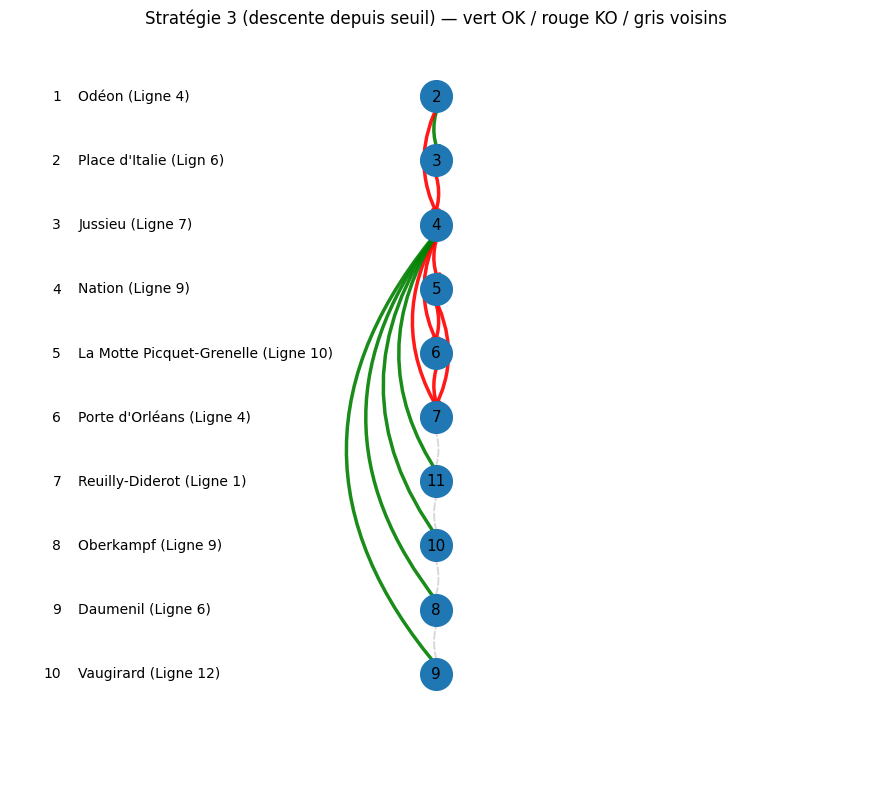

In [28]:
strategy3d_results, connected_rest, not_connected_rest = run_strategy_3_descend_from_threshold(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)

plot_strategy_graph(
    stations_ranked=stations_ranked,
    results=strategy3d_results,
    station_name_map=station_name_map,
    title="Stratégie 3 (descente depuis seuil) — vert OK / rouge KO / gris voisins",
    show_gray_neighbors=True,
    alternate_sides=True
)


## Stratégie 3, mais avec un 1-m

In [29]:
import inspect

def run_strategy_descend_with_fallback_1m(
    sorted_dataset,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True,
    margin_1m=1.0,
):
    """
    Stratégie:
      - ordre interne top-k (adjacent), en 1-1 puis fallback 1-m si besoin
      - HAUT (top-k au-dessus du seuil): descente vers le seuil en 1-1, puis fallback 1-m
      - BAS (hors top-k): redescente depuis le seuil en 1-1, puis fallback 1-m

    Retour:
      results : liste de dicts avec champs method, note, feasible, x, y, etc.
    """
    results = []
    n = len(sorted_dataset)
    top_k = min(top_k, n)

    topk = list(sorted_dataset[:top_k])
    rest = list(sorted_dataset[top_k:])

    pos = {node: i for i, node in enumerate(sorted_dataset)}  # 0-based
    k_idx = top_k - 1
    threshold = topk[-1] if top_k > 0 else None

    # --- helper: safe explain_kwargs for 1-m
    _one_to_many_params = set(inspect.signature(explain_one_to_many).parameters.keys())

    def _explain_kwargs_1m():
        # n'ajoute margin que si la fonction le supporte
        if "margin" in _one_to_many_params:
            return {"margin": margin_1m}
        return {}

    def compare_and_log(a, b, method, note=""):
        if verbose:
            prefix = f"[{method}] "
            if note:
                prefix += f"[{note}] "
            print(f"{prefix}Comparaison: {a} ≻ {b}")

        if method == "1-1":
            res = explain_pair(
                a, b,
                explain_fn=explain_one_to_one,
                explain_kwargs={},              # explicite
                eps_zero=eps_zero,
                gurobi_output=gurobi_output,
            )
        elif method == "1-m":
            res = explain_pair(
                a, b,
                explain_fn=explain_one_to_many,
                explain_kwargs=_explain_kwargs_1m(),
                eps_zero=eps_zero,
                gurobi_output=gurobi_output,
            )
        else:
            raise ValueError("method must be '1-1' or '1-m'")

        res["method"] = method
        res["note"] = note
        return res

    # 1) ordre interne top-k : 1≻2, 2≻3, ...
    for a, b in zip(topk[:-1], topk[1:]):
        r = compare_and_log(a, b, method="1-1", note="ordre top-k")
        results.append(r)
        if not r.get("feasible", False):
            r2 = compare_and_log(a, b, method="1-m", note="fallback ordre top-k")
            results.append(r2)

    if threshold is None:
        return results

    # 2) HAUT: descente vers le seuil (nouveau)
    for i in range(0, top_k - 1):  # 0..k-2
        si = topk[i]

        # candidats: seuil d'abord, puis i+1..k-2
        cand_indices = [top_k - 1] + list(range(i + 1, top_k - 1))
        candidates = [topk[j] for j in cand_indices]

        # A) 1-1: si ≻ cand
        success = False
        for cand in candidates:
            note = "haut seuil" if cand == threshold else f"haut descend via rang {pos[cand]+1}"
            r = compare_and_log(si, cand, method="1-1", note=note)
            results.append(r)
            if r.get("feasible", False):
                success = True
                break

        if success:
            continue

        # B) fallback 1-m: si ≻ cand
        for cand in candidates:
            note = "haut seuil" if cand == threshold else f"haut descend via rang {pos[cand]+1}"
            r = compare_and_log(si, cand, method="1-m", note=f"fallback {note}")
            results.append(r)
            if r.get("feasible", False):
                success = True
                break

        if verbose and not success:
            print(f"[ECHEC HAUT] Aucun chemin (1-1 puis 1-m) trouvé pour relier {si} au seuil.")

    # 3) BAS: ton bas inchangé (seuil..juste avant si)
    for si in rest:
        r_idx = pos[si]
        candidates = [sorted_dataset[j] for j in range(k_idx, r_idx)]

        # A) 1-1: cand ≻ si
        success = False
        for cand in candidates:
            note = "seuil" if cand == threshold else f"descend rang {pos[cand]+1}"
            r = compare_and_log(cand, si, method="1-1", note=note)
            results.append(r)
            if r.get("feasible", False):
                success = True
                break

        if success:
            continue

        # B) fallback 1-m
        for cand in candidates:
            note = "seuil" if cand == threshold else f"descend rang {pos[cand]+1}"
            r = compare_and_log(cand, si, method="1-m", note=f"fallback {note}")
            results.append(r)
            if r.get("feasible", False):
                success = True
                break

        if verbose and not success:
            print(f"[ECHEC BAS] Aucun chemin (1-1 puis 1-m) trouvé pour {si}.")

    return results


In [30]:
from utils_plots import plot_three_plots_from_descend_results

[1-1] [ordre top-k] Comparaison: 2 ≻ 3
[1-1] [ordre top-k] Comparaison: 3 ≻ 4
[1-m] [fallback ordre top-k] Comparaison: 3 ≻ 4
[1-1] [haut seuil] Comparaison: 2 ≻ 4
[1-1] [haut descend via rang 2] Comparaison: 2 ≻ 3
[1-1] [haut seuil] Comparaison: 3 ≻ 4
[1-m] [fallback haut seuil] Comparaison: 3 ≻ 4
[ECHEC HAUT] Aucun chemin (1-1 puis 1-m) trouvé pour relier 3 au seuil.
[1-1] [seuil] Comparaison: 4 ≻ 5
[1-m] [fallback seuil] Comparaison: 4 ≻ 5
[ECHEC BAS] Aucun chemin (1-1 puis 1-m) trouvé pour 5.
[1-1] [seuil] Comparaison: 4 ≻ 6
[1-1] [descend rang 4] Comparaison: 5 ≻ 6
[1-m] [fallback seuil] Comparaison: 4 ≻ 6
[1-m] [fallback descend rang 4] Comparaison: 5 ≻ 6
[ECHEC BAS] Aucun chemin (1-1 puis 1-m) trouvé pour 6.
[1-1] [seuil] Comparaison: 4 ≻ 7
[1-1] [descend rang 4] Comparaison: 5 ≻ 7
[1-1] [descend rang 5] Comparaison: 6 ≻ 7
[1-m] [fallback seuil] Comparaison: 4 ≻ 7
[1-m] [fallback descend rang 4] Comparaison: 5 ≻ 7
[1-1] [seuil] Comparaison: 4 ≻ 11
[1-1] [seuil] Comparaison: 4 ≻ 

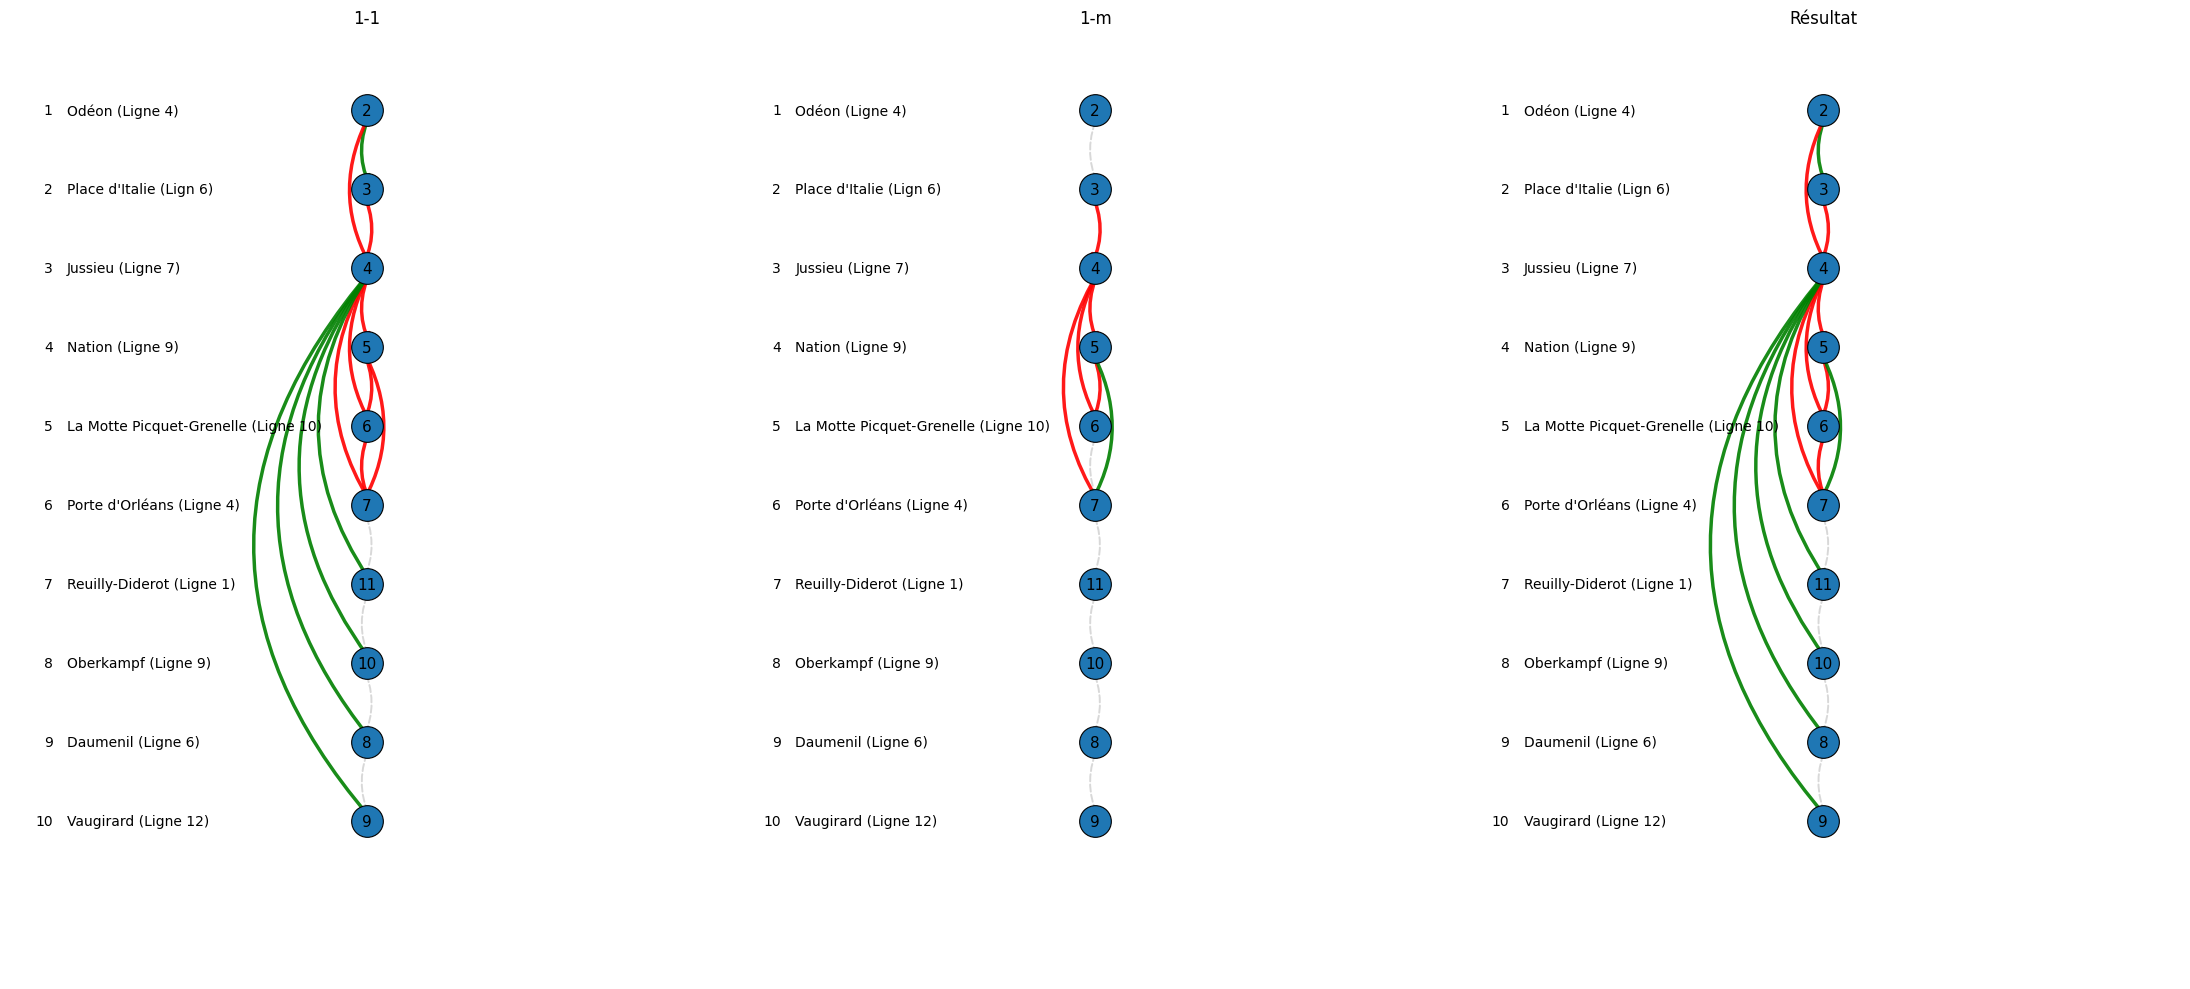

In [31]:
strategy_results = run_strategy_descend_with_fallback_1m(
    sorted_dataset=stations_ranked,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True
)

plot_three_plots_from_descend_results(
    stations_ranked=stations_ranked,
    results_mixed=strategy_results,
    station_name_map=station_name_map,
    show_gray_neighbors=True,
    alternate_sides=True,
    prefer_feasible=True
)


In [32]:
def run_strategy_descend_with_fallback_1m_m1_mixte(
    sorted_dataset,
    top_k=3,
    eps_zero=0.0,
    gurobi_output=False,
    verbose=True,
    eps_pos_1m=1e-9,
    eps_pos_m1=0.0,
    eps_pos_mix=1e-9,
    fallback_order=("1-m", "m-1", "mix"),  # tu peux changer l'ordre ici
):
    """
    Stratégie descendante en cascade:
      - HAUT (top-k au-dessus du seuil): descente vers le seuil (procédure du bas mais inversée)
      - BAS (hors top-k): descente depuis le seuil

    Cascade de méthodes: "1-1" puis fallback_order (par défaut 1-m, m-1, mixte)

    Retour:
      results : liste de dicts {x,y,feasible,method,note,...}
    """
    results = []
    n = len(sorted_dataset)
    if n == 0:
        return results

    top_k = min(top_k, n)
    topk = list(sorted_dataset[:top_k])
    rest = list(sorted_dataset[top_k:])

    pos = {node: i for i, node in enumerate(sorted_dataset)}  # 0-based
    k_idx = top_k - 1
    threshold = topk[-1] if top_k > 0 else None

    # method -> (fn, kwargs)
    METHOD = {
        "1-1": (explain_one_to_one, {}),
        "1-m": (explain_one_to_many, {"eps_pos": eps_pos_1m}),
        "m-1": (explain_many_to_one, {"eps_pos": eps_pos_m1}),
        "mix": (explain_one_or_many, {"eps_pos": eps_pos_mix}),
    }

    def compare_and_log(a, b, method, note=""):
        if method not in METHOD:
            raise ValueError(f"Unknown method '{method}'. Allowed: {list(METHOD.keys())}")

        if verbose:
            prefix = f"[{method}] "
            if note:
                prefix += f"[{note}] "
            print(f"{prefix}Comparaison: {a} ≻ {b}")

        fn, kwargs = METHOD[method]

        res = explain_pair(
            a, b,
            explain_fn=fn,
            explain_kwargs=kwargs if kwargs else None,
            eps_zero=eps_zero,
            gurobi_output=gurobi_output,
        )
        res["method"] = method
        res["note"] = note
        return res


    if threshold is None:
        return results

    # 2) HAUT: procédure du bas mais inversée (si ≻ cand), en cascade
    #    Pour chaque si dans top-k sauf le seuil, on cherche un cand parmi ceux sous si jusqu'au seuil.
    for si in topk[:-1]:  # exclut threshold
        si_idx = pos[si]
        thr_idx = pos[threshold]  # = k_idx

        # candidats "sous si" mais >= seuil (donc indices si_idx+1 .. thr_idx)
        # on met le seuil en premier (comme bas commence par seuil), puis on remonte vers juste sous si
        candidates = [sorted_dataset[j] for j in range(thr_idx, si_idx, -1)]  # thr_idx, ..., si_idx+1

        found = False
        for method in ("1-1",) + tuple(fallback_order):
            for cand in candidates:
                note = "haut seuil" if cand == threshold else f"haut descend rang {pos[cand] + 1}"
                note2 = note if method == "1-1" else f"fallback {note}"
                rr = compare_and_log(si, cand, method=method, note=note2)  # <-- inversé: si ≻ cand
                results.append(rr)
                if rr.get("feasible", False):
                    found = True
                    break
            if found:
                break

        if not found and verbose:
            print(f"[ECHEC HAUT] Aucun chemin (1-1 puis {fallback_order}) trouvé pour relier {si} au seuil.")

    # 3) BAS: on garde EXACTEMENT ta procédure (inchangée)
    if not rest:
        return results

    for si in rest:
        r_idx = pos[si]
        candidates = [sorted_dataset[j] for j in range(k_idx, r_idx)]  # seuil..(juste avant si)

        found = False
        for method in ("1-1",) + tuple(fallback_order):
            for cand in candidates:
                note = "seuil" if cand == threshold else f"descend rang {pos[cand] + 1}"
                note2 = note if method == "1-1" else f"fallback {note}"
                rr = compare_and_log(cand, si, method=method, note=note2)
                results.append(rr)
                if rr.get("feasible", False):
                    found = True
                    break
            if found:
                break

        if not found and verbose:
            print(f"[ECHEC] Aucun chemin (1-1 puis {fallback_order}) trouvé pour {si}.")

    return results


In [33]:
from utils_plots import plot_five_panels

[1-1] [haut seuil] Comparaison: 2 ≻ 4
[1-1] [haut descend rang 2] Comparaison: 2 ≻ 3
[1-1] [haut seuil] Comparaison: 3 ≻ 4
[1-m] [fallback haut seuil] Comparaison: 3 ≻ 4
[m-1] [fallback haut seuil] Comparaison: 3 ≻ 4
[1-1] [seuil] Comparaison: 4 ≻ 5
[1-m] [fallback seuil] Comparaison: 4 ≻ 5
[m-1] [fallback seuil] Comparaison: 4 ≻ 5
[mix] [fallback seuil] Comparaison: 4 ≻ 5
[1-1] [seuil] Comparaison: 4 ≻ 6
[1-1] [descend rang 4] Comparaison: 5 ≻ 6
[1-m] [fallback seuil] Comparaison: 4 ≻ 6
[1-m] [fallback descend rang 4] Comparaison: 5 ≻ 6
[m-1] [fallback seuil] Comparaison: 4 ≻ 6
[m-1] [fallback descend rang 4] Comparaison: 5 ≻ 6
[1-1] [seuil] Comparaison: 4 ≻ 7
[1-1] [descend rang 4] Comparaison: 5 ≻ 7
[1-1] [descend rang 5] Comparaison: 6 ≻ 7
[1-m] [fallback seuil] Comparaison: 4 ≻ 7
[1-m] [fallback descend rang 4] Comparaison: 5 ≻ 7
[1-1] [seuil] Comparaison: 4 ≻ 11
[1-1] [seuil] Comparaison: 4 ≻ 10
[1-1] [seuil] Comparaison: 4 ≻ 8
[1-1] [seuil] Comparaison: 4 ≻ 9


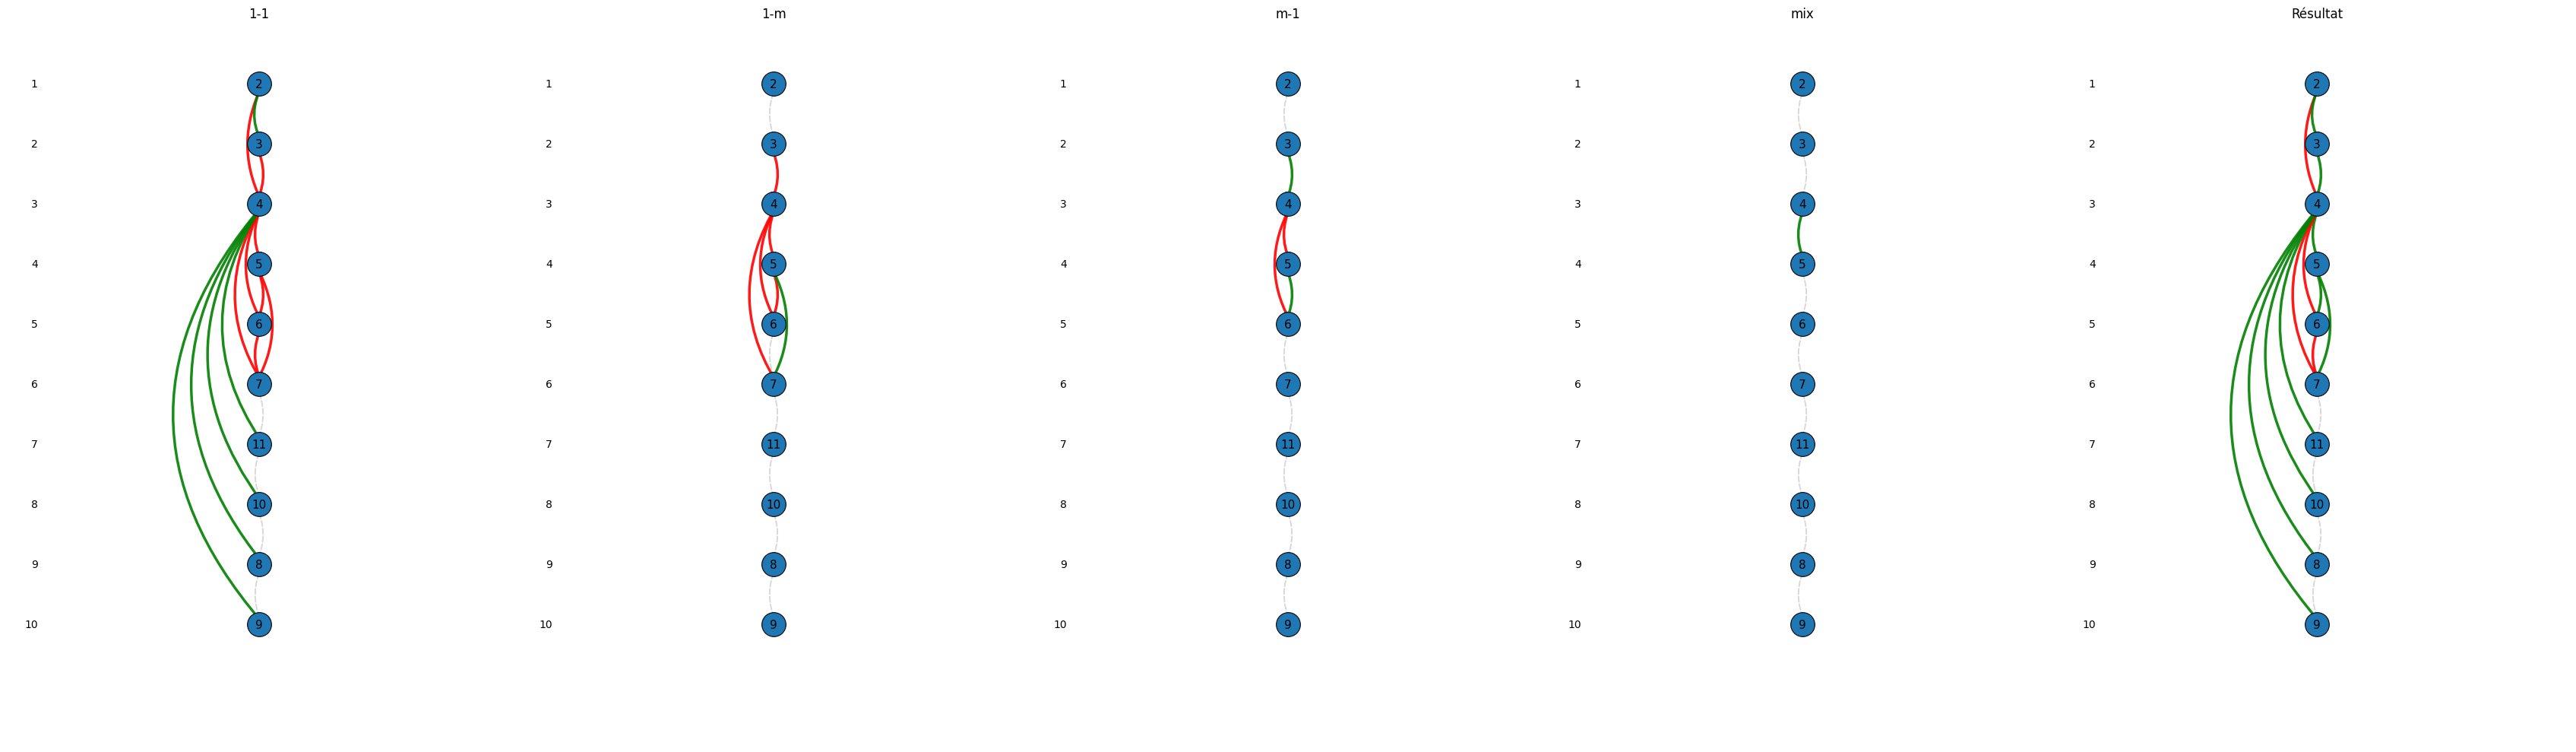

In [34]:
results = run_strategy_descend_with_fallback_1m_m1_mixte(
    sorted_dataset=stations_ranked,  
    top_k=3,
    eps_zero=0.0,
    eps_pos_1m=1e-9,
    eps_pos_m1=0.0,
    eps_pos_mix=1e-9,
    fallback_order=("1-m","m-1","mix"),
    verbose=True,
)



plot_five_panels(
    stations_ranked,
    results,
    priority=("mix", "m-1", "1-m", "1-1"),
    mix_method_name="mix",
)


In [35]:
from utils_plots import plot_results_as_tree_like_last_panel

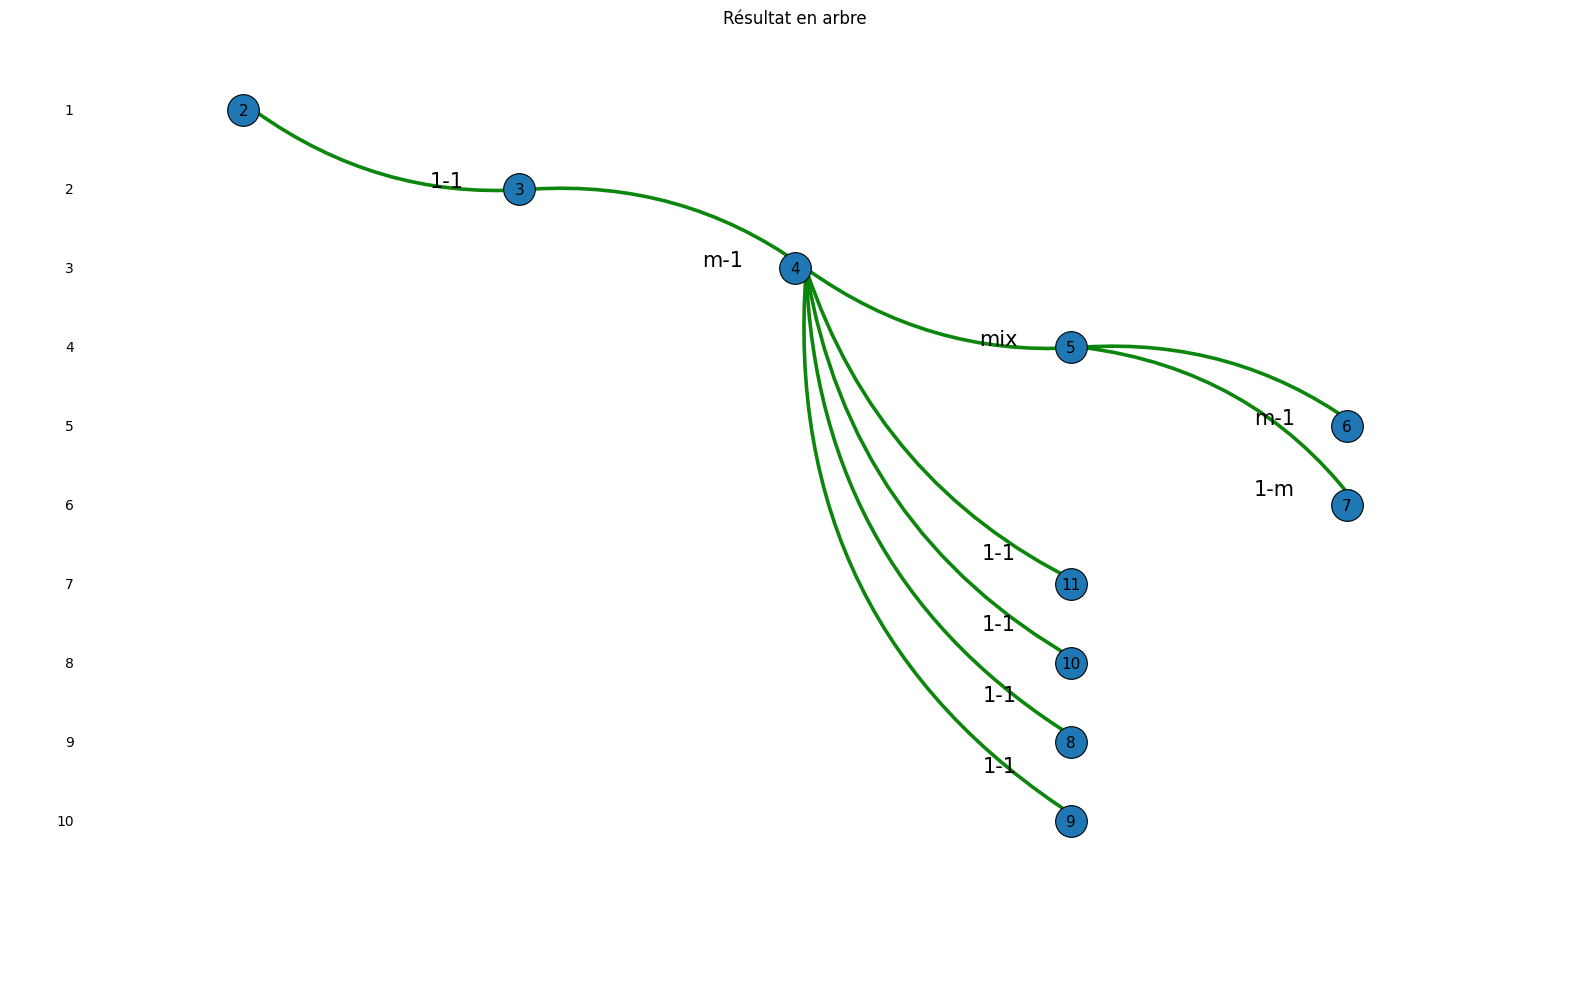

In [36]:
plot_results_as_tree_like_last_panel(
    stations_ranked,
    results
)